In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import  layers , models ,optimizers
from tensorflow import  keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import imgaug.augmenters as iaa


# **extract the images and it's label for training and test images**

In [ ]:
dataset_path = '/kaggle/input/smoking/Training/Training'
img_size = 250

train_data = []
train_labels = []
train_paths = []

for img_name in os.listdir(dataset_path):

    if(img_name[:3] == 'not'):
      img_class = 'notsmoking'
    else :
      img_class = 'smoking'
    train_labels.append(img_class)
    img_path = os.path.join(dataset_path, img_name)
    train_paths.append(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    train_data.append([img,img_class])

In [ ]:
train_data[0][1]

'smoking'

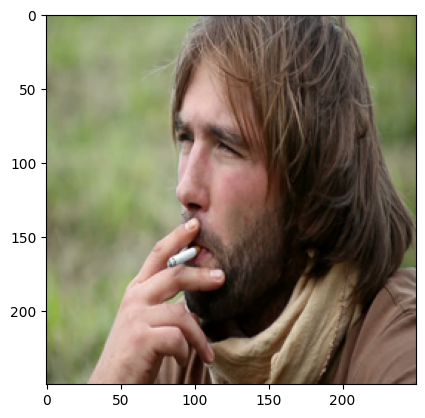

In [ ]:
plt.imshow(train_data[0][0])

In [ ]:
train_paths[:3]

['/kaggle/input/smoking/Training/Training/smoking_0382.jpg',
 '/kaggle/input/smoking/Training/Training/notsmoking_0544.jpg',
 '/kaggle/input/smoking/Training/Training/smoking_0022.jpg']

In [ ]:
train_labels[:3]

['smoking', 'notsmoking', 'smoking']

In [ ]:
dataset_path = '/kaggle/input/smoking/Testing/Testing'

test_data = []
test_labels = []
test_paths = []

for img_name in os.listdir(dataset_path):
    if(img_name[:3] == 'not'):
      img_class = 'notsmoking'
    else :
      img_class = 'smoking'
    test_labels.append(img_class)
    img_path = os.path.join(dataset_path, img_name)
    test_paths.append(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_data.append([img,img_class])


In [ ]:
test_data[0][1]

'notsmoking'

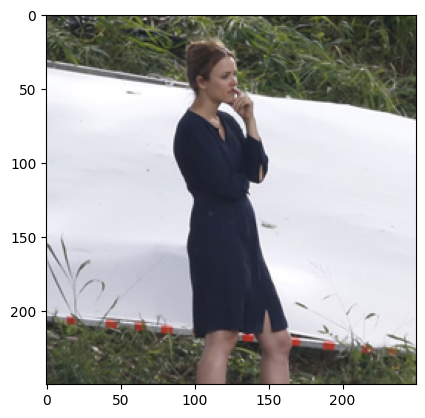

In [ ]:
plt.imshow(test_data[0][0])


In [ ]:
test_paths[:3]

['/kaggle/input/smoking/Testing/Testing/notsmoking_0041.jpg',
 '/kaggle/input/smoking/Testing/Testing/smoking_0196.jpg',
 '/kaggle/input/smoking/Testing/Testing/notsmoking_0433.jpg']

In [ ]:
test_labels[:3]

['notsmoking', 'smoking', 'notsmoking']

# display some random images

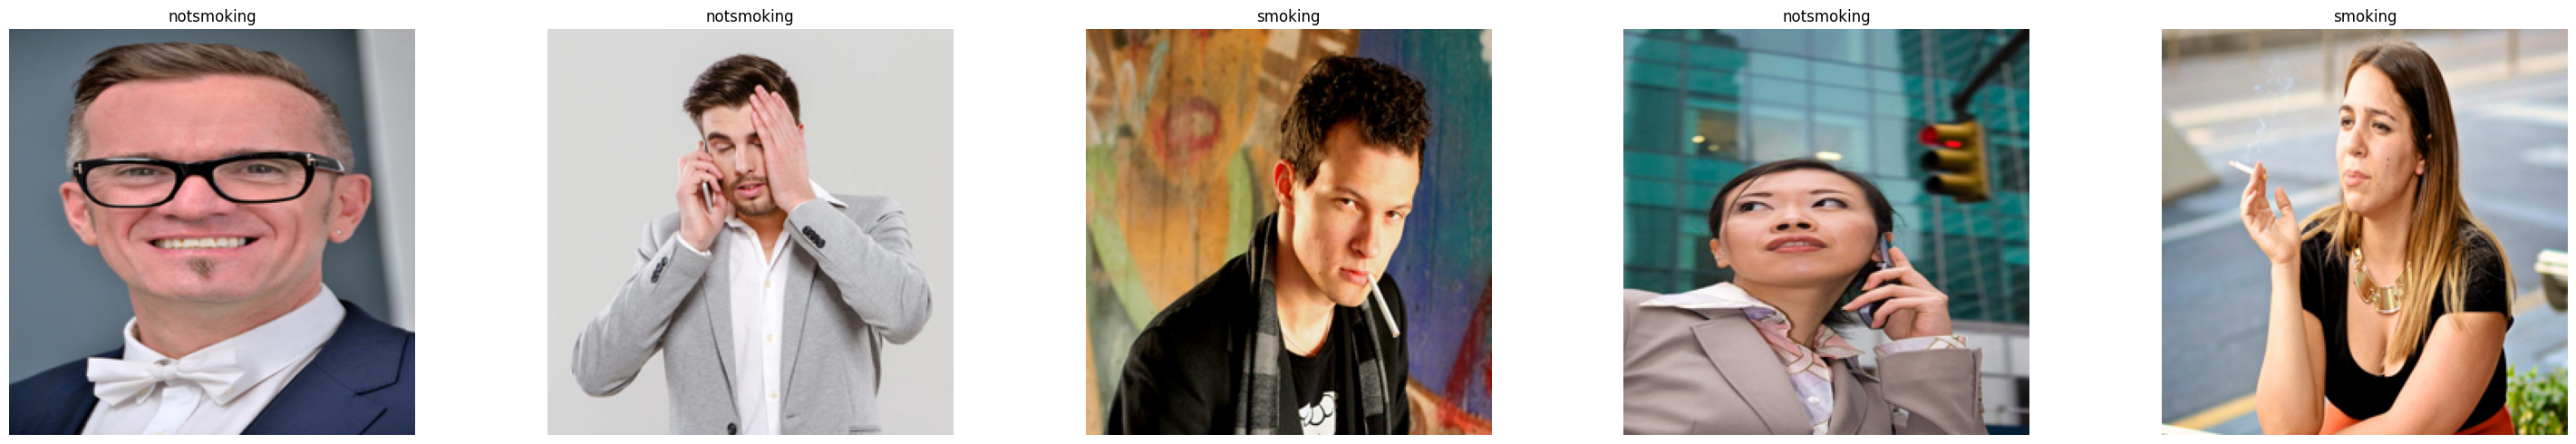

In [ ]:
def display_random_images(images, labels, num_images=5):
    num_total_images = len(images)
    random_indices = np.random.choice(num_total_images, size=num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(30, 5))
    for i, idx in enumerate(random_indices):
        axes[i].imshow(images[idx][0])

        axes[i].set_title(labels[idx])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

display_random_images(train_data, train_labels)

# shuffle data

In [ ]:
random.shuffle(train_data)
random.shuffle(test_data)


In [ ]:
for item in train_data[:3]:
  print(item[1])

notsmoking
notsmoking
smoking


# split train and test

In [ ]:
x_train , x_test , y_train , y_test = [] , [] , [] , []

def extract_splits(data):
    for features ,label  in data  :

        if(data == train_data):
            x_train.append(features)
            y_train.append(label)
        else:
            x_test.append(features)
            y_test.append(label)

In [ ]:
extract_splits(train_data)

In [ ]:
extract_splits(test_data)

# turn data into numpy array

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
print("x_train shape ",x_train.shape)
print("y_train shape ",y_train.shape)

print("x_test shape ",x_test.shape)
print("y_test shape ",y_test.shape)

x_train shape  (716, 250, 250, 3)
y_train shape  (716,)
x_test shape  (224, 250, 250, 3)
y_test shape  (224,)


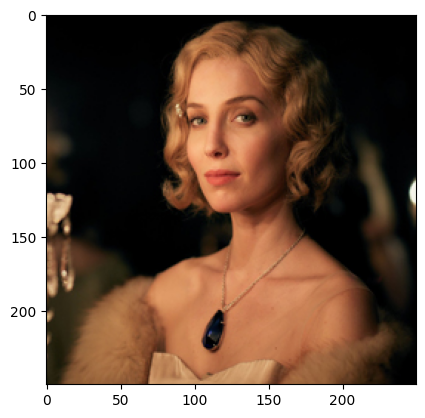

In [ ]:
plt.imshow(x_train[3])

In [ ]:
y_train[3]


'notsmoking'

# encode the labels using label encoder

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)


In [ ]:
y_train_encoded[0]

0

# data augmantaion

In [ ]:
def display_seq_images(images, labels, num_images=5):
    num_total_images = len(images)

    fig, axes = plt.subplots(1, num_images, figsize=(30, 5))
    for i, idx in enumerate(range(num_images)):
        axes[i].imshow(images[idx], aspect='auto')

        axes[i].set_title(labels[idx])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:

def augment_images(images, labels, num_augmentations=4):
    augmented_images = []
    augmented_labels = []


    seq = iaa.Sequential([
        iaa.Fliplr(1.0),
        iaa.Multiply((1.5, 2.5), per_channel=0.5)
    ])


    for original_image, label in zip(images, labels):
        augmented_images.append(original_image)
        augmented_labels.append(label)


        augmented_images.extend(seq(images=[original_image] * (num_augmentations)))
        augmented_labels.extend([label] * (num_augmentations))

    return np.array(augmented_images), np.array(augmented_labels)

num_augmentations = 4

augmented_images,augmented_labels = augment_images(x_train,y_train_encoded ,num_augmentations)

In [ ]:
y_train_encoded[0]

0

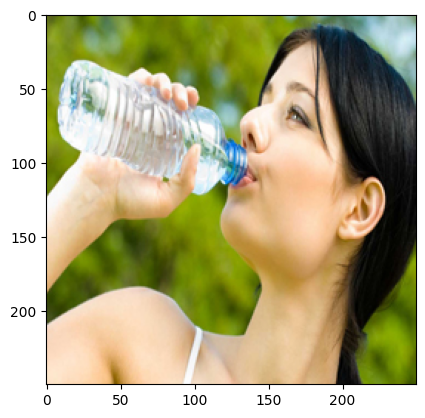

In [ ]:
plt.imshow(augmented_images[0])

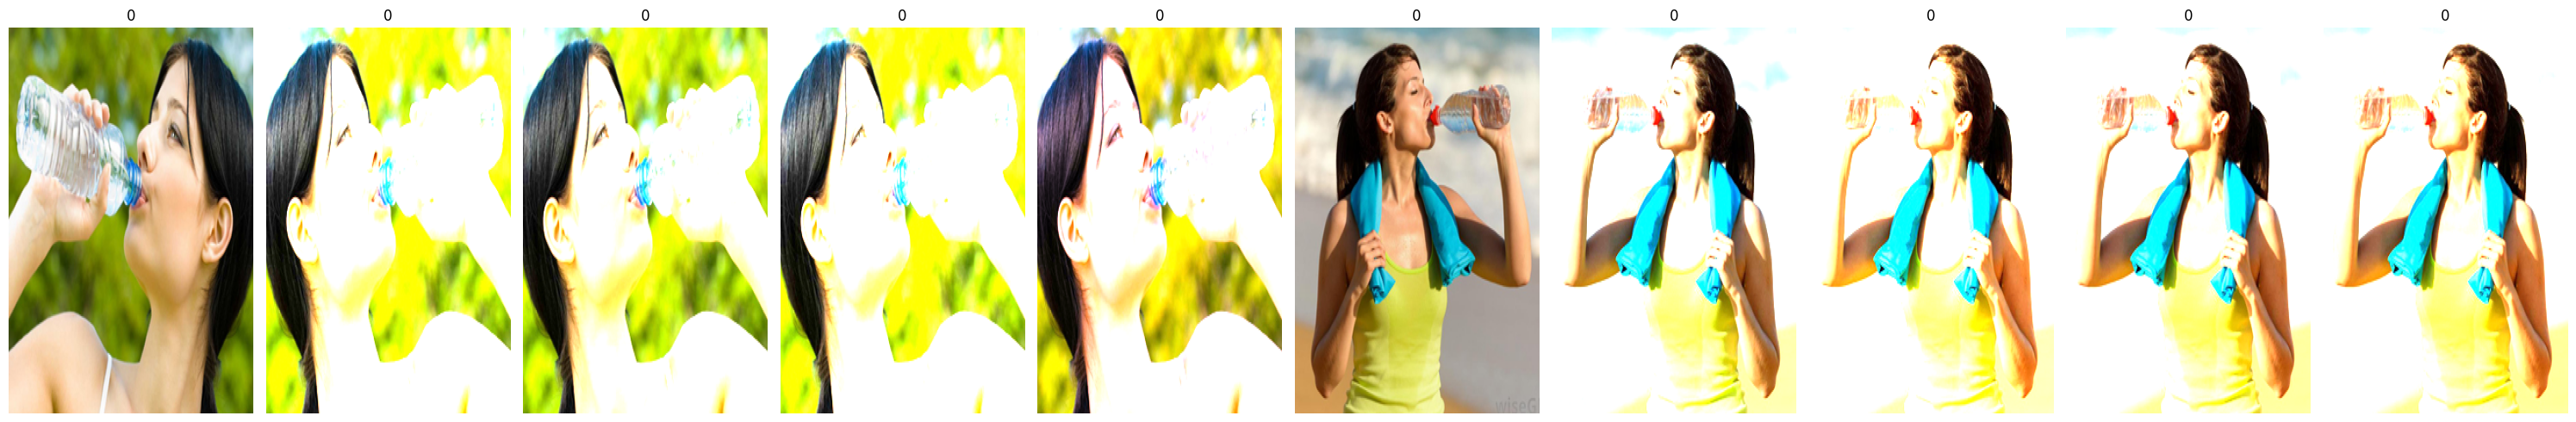

In [ ]:
display_seq_images(augmented_images,augmented_labels,10)

In [ ]:
augmented_images.shape

(3580, 250, 250, 3)

In [ ]:
augmented_labels.shape

(3580,)

# rescale images

In [ ]:
augmented_images[0].shape

(250, 250, 3)

In [ ]:
preprocess_input = keras.applications.mobilenet_v3.preprocess_input


# MobileNetV3Large model without fine tuning

In [ ]:
img_shape = augmented_images[0].shape
base_model = keras.applications.MobileNetV3Large(
    input_shape=img_shape,
    include_top=False,
    weights="imagenet",

)

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 250, 250, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 125, 125, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 125, 125, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [ ]:

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


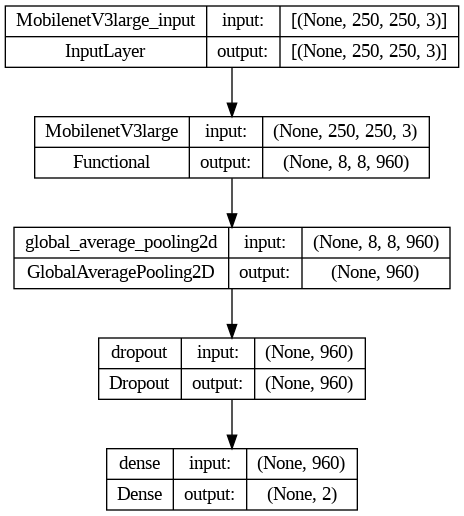

In [ ]:
tf.keras.utils.plot_model(model , show_shapes = True)

In [ ]:
augmented_labels[0].dtype


dtype('int64')

In [ ]:
epochs=30

In [ ]:
batch_size = 32

history = model.fit(augmented_images, augmented_labels, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_encoded))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# MobileNetV3Large with fine tuning

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_layers = 100

for layer in base_model.layers[:fine_tune_layers]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 25
total_epochs = epochs + fine_tune_epochs
batch_size = 32

history_tuned = model.fit(augmented_images, augmented_labels, epochs=total_epochs,initial_epoch = history.epoch[-1], batch_size=batch_size, validation_data=(x_test, y_test_encoded))


Epoch 30/55
112/112 [==============================] - 33s 107ms/step - loss: 0.4999 - accuracy: 0.7659 - val_loss: 0.1765 - val_accuracy: 0.9330
Epoch 31/55
112/112 [==============================] - 10s 85ms/step - loss: 0.4060 - accuracy: 0.8226 - val_loss: 0.1707 - val_accuracy: 0.9375
Epoch 32/55
112/112 [==============================] - 10s 86ms/step - loss: 0.3558 - accuracy: 0.8394 - val_loss: 0.1693 - val_accuracy: 0.9375
Epoch 33/55
112/112 [==============================] - 10s 86ms/step - loss: 0.3306 - accuracy: 0.8564 - val_loss: 0.1668 - val_accuracy: 0.9375
Epoch 34/55
112/112 [==============================] - 10s 86ms/step - loss: 0.2830 - accuracy: 0.8821 - val_loss: 0.1590 - val_accuracy: 0.9330
Epoch 35/55
112/112 [==============================] - 9s 84ms/step - loss: 0.2499 - accuracy: 0.9036 - val_loss: 0.1577 - val_accuracy: 0.9375
Epoch 36/55
112/112 [==============================] - 9s 85ms/step - loss: 0.2236 - accuracy: 0.9148 - val_loss: 0.1541 - val_acc

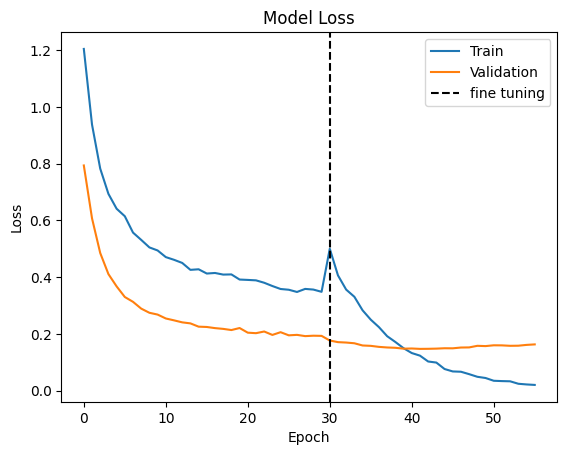

In [ ]:
combined_loss = history.history['loss'] +  history_tuned.history['loss']
combined_val_loss = history.history['val_loss'] +  history_tuned.history['val_loss']

plt.plot(combined_loss)
plt.plot(combined_val_loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.axvline(x=len(history.history['loss']), color='k', linestyle='--')
plt.legend(['Train', 'Validation','fine tuning'], loc='upper right')
plt.show()

# model predictions

In [ ]:
predictions = model.predict(x_test)

7/7 [==============================] - 2s 49ms/step


In [ ]:
predictions[0]

array([0.967228  , 0.03277197], dtype=float32)

In [ ]:
class_name = {1: 'smoking', 0: 'notsmoking'}
def plot_image(i,pred_array,true_label,img):
  pred_array , true_label , img= pred_array[i] , true_label[i] , img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img,cmap=plt.cm.binary)
  predicted_label = np.argmax(pred_array)


  if(predicted_label == true_label):
      color='blue'
  else:
     color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                        100*np.max(pred_array),
                                        class_name[true_label])).set_color(color)
  plt.title("Image {}".format(i + 1))


def plot_activation_value(i,pred_array,true_label):
  pred_array , true_label = pred_array[i] , true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(2),pred_array,color="#777777")
  plt.ylim([0,1])
  predicted_label = np.argmax(pred_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  top_classes = np.argsort(pred_array)[-3:][::-1]


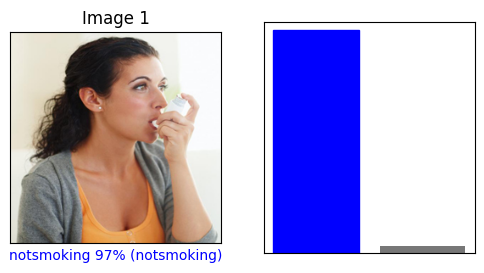

In [ ]:
i=0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i , predictions , y_test_encoded , x_test)
plt.subplot(1,2,2)
plot_activation_value(i,predictions,y_test_encoded)
plt.show()

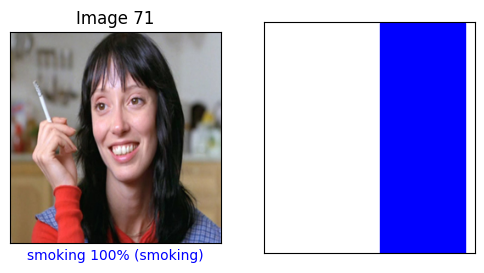

In [ ]:
i=70
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i , predictions , y_test_encoded , x_test)
plt.subplot(1,2,2)
plot_activation_value(i,predictions,y_test_encoded)
plt.show()

In [ ]:

import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [ ]:
model.save("model_one.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 47ms/step


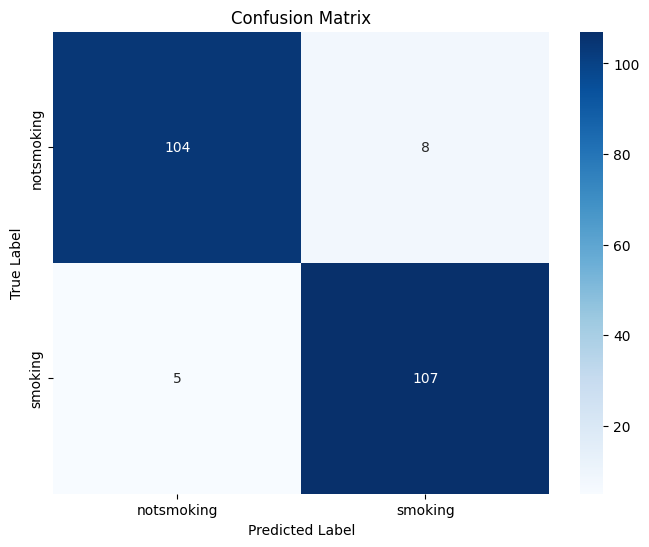

In [ ]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_encoded, y_pred_classes)

class_labels = ['notsmoking', 'smoking']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:


from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():

  path = '/content/' + fn
  img = cv2.imread(path)
  img = cv2.resize(img, (img_size,img_size))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis('off')
  plt.show()


  img_array = np.array(img)


  img_array = img_array.reshape(1, img_size, img_size, 3)


  img_array = preprocess_input(img_array)

  predictions = model.predict(img_array)


  predicted_class = np.argmax(predictions)


  class_name = class_labels[predicted_class]

  print(f"Predicted class: {class_name}")
  print(f"Probability: {predictions[0][predicted_class]:.2f}")
